## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 7 дней после окончания последнего вебинара.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd
import pickle
import random
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm, catboost as catb
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, 
                             plot_roc_curve, f1_score, precision_score, recall_score)

from scipy.stats import shapiro, probplot, mannwhitneyu, chi2_contingency

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

**Пути к директориям и файлам**

In [4]:
TRAIN_DATASET_PATH = '/kaggle/input/gb-credit-default/train.csv'
TEST_DATASET_PATH = '/kaggle/input/gb-credit-default/test.csv'

**Загрузка данных**

In [5]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [8]:
df_train.shape[0]

7500

In [9]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [10]:
df_test.shape[0]

2500

#### Обзор целевой переменной ####

In [11]:
df_train['Credit Default'].value_counts() # Есть неравномерность распределения

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Обзор количественных признаков ####

In [12]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Данные неоднородные. Имеются пропуски, экстремальные минимальные и максимальные значения. Необходима предварительная обработка.

Пропуски: **Annual Income** (20%), **Months since last delinquent** (50%), **Bankruptcies** (<1%), **Credit Score** (20%).

Экстремальные максимальные значения: **Annual Income**, **Maximum Open Credit**, **Current Loan Amount**, **Current Credit Balance**.

In [13]:
for cat_colname in df_train.select_dtypes(include=('float64', 'int64')).columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Annual Income

1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      2
37.0      

1. **Annual Income.** 
Практически все значения уникальны. Можно попробовать группировать по нескольким диапазонам. Например, < 1 млн., 1-5 млн, 5-9 млн, > 9 млн. Возможно, свыше 9 млн. - это выборсы.

2. **Tax Liens.** 
Большинство случаев не имеет налоговых обременений. Значения больше 3-х можно посчитать как выбросы (11 случаев).

3. **Number of Open Accounts.** 
Значения разнообразны. Можно попробовать группировать, например, < 5, 5-10, 10-15, 15-20, > 20. Более 50 можно посчитать как выбросы.

4. **Years of Credit History.** 
Значения разнообразны. Большинство значений около 13-20 лет. Подробнее изучить экстремальные значения около нуля или больше 30 лет.

5. **Maximum Open Credit.** 
Данные разнообразны, однако 65 значений равны нулю. Возможно их стоит заполнить средним/медианой или выделить в отдельную группу.

6. **Number of Credit Problems.** 
Большинство случаев не имеет проблем с кредитом. Значения больше 3-х можно посчитать как выбросы (21 случай).

7. **Months since last delinquent.** 
Данные разнообразны. Значения больше 100 можно посчитать как выбросы.

8. **Bankruptcies.** 
В большинстве случаев банкротсв не было. Значения больше 2-х можно посчитать как выбросы (9 случаев).

9. **Current Loan Amount.** 
Много случаев с суммой 99999999.0. Не совсем понятно, это некорректно введенные данные, либо действительно распространенная сумма выдачи кредита. Можно попробовать вынести в отдельную группу.

10. **Current Credit Balance.** 
Разброс значений от 0 до 6,5 млн. Большинство значений меньше 360 тыс. Вероятно, значения около 6 млн можно считать как выбросы.

11. **Monthly Debt.** 
Разброс значений от 0 до 136 тыс. Большинство значений меньше 24 тыс. Необходимо рассмотреть значения более 100 тыс. подробнее.

12. **Credit Score.** 
Разброс значений от 585 до 7510. Большинство значений меньше 742. Необходимо рассмотреть значения более 1000 подробнее.

#### Обзор номинативных признаков ####

In [14]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Есть пропуски в признаке **Years in current job**.
1. **Home Ownership.** 
Основное распределение значений между ипотекой на дом и арендой. Не понятна группа **Have Mortgage**, возможно это опечатка и можно отнести эту группу к ипотеке на дом.
2. **Years in current job.**
Большое количество значений у "более 10 лет работы на текущей позиции". Можно попробовать группировать, например, < 1, 1-5, 5-10, > 10. Значение NaN заполнить модой.
3. **Purpose.**
Пока не понятно насколько полезный данный признак. Основная масса значений **debt consolidation**, возможно, категории меньше 10 следует объединить с категорией **other** (10 случаев).
4. **Term.**
Сильный перевес значений в сторону краткосрочных кредитов.

### Обзов пропусков ###

In [15]:
df_train.loc[df_train['Annual Income'].isnull()].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1


In [16]:
df_train.loc[df_train['Months since last delinquent'].isnull()].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [17]:
df_train.loc[df_train['Bankruptcies'].isnull()].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
100,Own Home,337079.0,1 year,0.0,9.0,39.6,644204.0,0.0,0.0,NaN,educational expenses,Short Term,99999999.0,224770.0,4326.0,734.0,0
256,Rent,857660.0,1 year,0.0,6.0,19.7,291082.0,0.0,0.0,NaN,debt consolidation,Short Term,99999999.0,236816.0,3488.0,743.0,0
257,Home Mortgage,NaN,2 years,0.0,15.0,13.6,1556390.0,0.0,0.0,NaN,debt consolidation,Short Term,447480.0,524210.0,19613.0,NaN,0
898,Rent,739005.0,2 years,0.0,20.0,18.3,2177758.0,0.0,0.0,NaN,debt consolidation,Short Term,456808.0,607487.0,9669.0,732.0,1
1404,Rent,349391.0,< 1 year,0.0,4.0,12.7,0.0,0.0,0.0,NaN,other,Short Term,11242.0,0.0,1243.0,747.0,0


In [18]:
df_train.loc[df_train['Credit Score'].isnull()].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1


In [19]:
df_train.loc[df_train['Years in current job'].isnull()].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
24,Own Home,NaN,NaN,0.0,12.0,25.0,1216336.0,0.0,61.0,0.0,debt consolidation,Short Term,467676.0,818311.0,37530.0,NaN,0
58,Home Mortgage,992845.0,NaN,0.0,17.0,21.2,1132054.0,0.0,NaN,0.0,debt consolidation,Short Term,207812.0,294291.0,25483.0,739.0,0
60,Home Mortgage,1630029.0,NaN,0.0,10.0,17.3,697114.0,0.0,NaN,0.0,debt consolidation,Long Term,230362.0,260680.0,6181.0,714.0,0


### Обзор выбросов ###

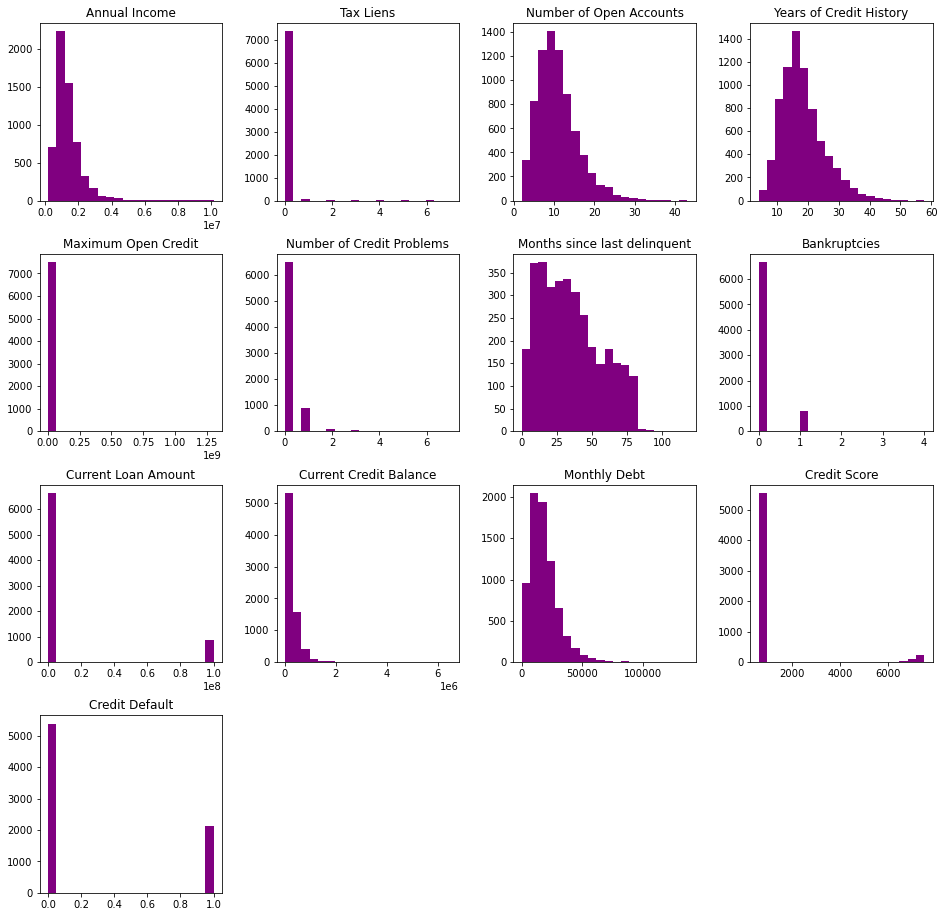

In [20]:
df_train_num_features = df_train.select_dtypes(include=['float64', 'int64'])
df_train_num_features.hist(figsize=(16,16), bins=20, grid=False, color='purple');

In [21]:
df_train.loc[df_train['Annual Income'] > 9000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
2200,Rent,9338880.0,10+ years,0.0,7.0,7.3,1092608.0,0.0,NaN,0.0,business loan,Short Term,788480.0,326496.0,40546.0,720.0,0
6472,Rent,10149344.0,5 years,0.0,10.0,17.5,270380.0,0.0,22.0,0.0,debt consolidation,Short Term,664818.0,205713.0,61235.0,692.0,0


In [22]:
df_train.loc[df_train['Maximum Open Credit'] > 20000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,99999999.0,1908550.0,5770.0,743.0,0
4769,Home Mortgage,3739960.0,9 years,0.0,7.0,22.8,2.634333e+07,0.0,NaN,0.0,home improvements,Short Term,757834.0,6506797.0,38023.0,703.0,0
5523,Home Mortgage,1520304.0,10+ years,0.0,21.0,35.5,2.137243e+07,0.0,0.0,0.0,other,Long Term,99999999.0,1975012.0,12555.0,728.0,0
7026,Home Mortgage,3312365.0,5 years,0.0,13.0,25.3,2.640700e+07,0.0,50.0,0.0,home improvements,Long Term,99999999.0,2440246.0,39196.0,745.0,0


In [23]:
df_train.loc[df_train['Current Loan Amount'] == 99999999].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0


In [24]:
df_train.loc[df_train['Current Credit Balance'] > 2000000].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
93,Home Mortgage,NaN,10+ years,0.0,18.0,17.9,3028014.0,0.0,NaN,0.0,debt consolidation,Short Term,311168.0,2327443.0,55716.0,NaN,0
162,Home Mortgage,2131591.0,< 1 year,0.0,15.0,31.7,4191176.0,0.0,NaN,0.0,debt consolidation,Short Term,269258.0,3547262.0,20783.0,728.0,0
604,Home Mortgage,2822773.0,1 year,0.0,13.0,29.5,3409934.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,2612177.0,50810.0,727.0,0
837,Home Mortgage,5131482.0,2 years,0.0,16.0,20.7,4860504.0,0.0,16.0,0.0,debt consolidation,Short Term,756228.0,2833451.0,44473.0,737.0,0
1211,Own Home,2150477.0,8 years,0.0,31.0,31.3,3866918.0,0.0,NaN,0.0,debt consolidation,Long Term,757834.0,2063875.0,70966.0,722.0,0


#### График распределения целевой переменной ####

In [25]:
y_train = df_train['Credit Default']

In [26]:
name_features = df_train.columns[:-1]
name_features

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'],
      dtype='object')

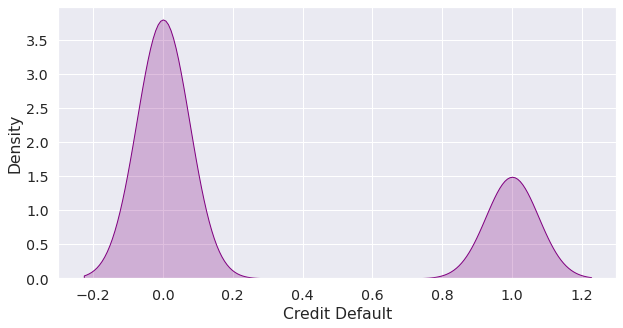

In [27]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.3)
sns.kdeplot(y_train, shade=True, color='purple')
plt.show()

In [28]:
shapiro(y_train)

ShapiroResult(statistic=0.5633193254470825, pvalue=0.0)

Как видно из графика выше **целевая переменная не имеет нормального распределения**, это же подтверждает и критерий Шапиро-Уилко. Получившееся значение **p-value** меньше 0.05. У переменной есть два ярко выраженных центра в 0 и 1, при этом значений в нуле гораздо больше.

#### Гистограммы наиболее проблемных признаков ####

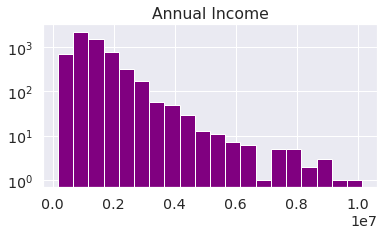

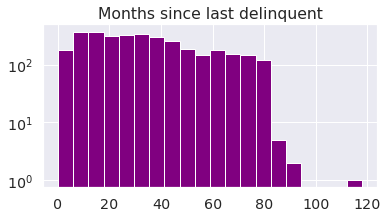

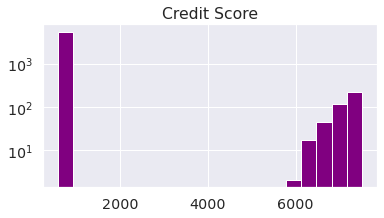

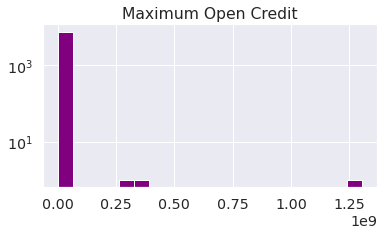

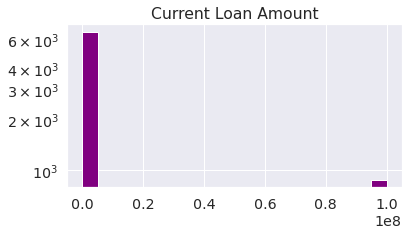

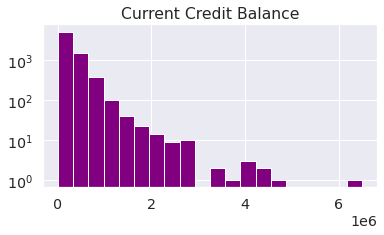

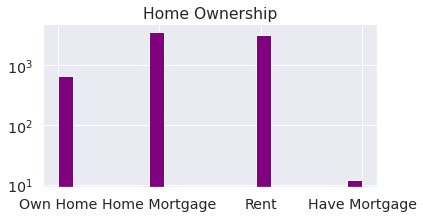

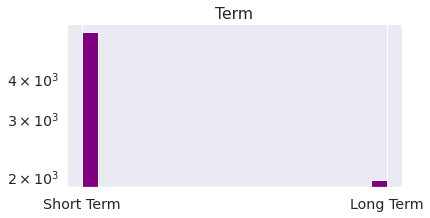

In [29]:
figsize = (6, 3)
for name in ['Annual Income', 'Months since last delinquent', 'Credit Score', \
             'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', \
             'Home Ownership', 'Term']:
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.3)
    plt.hist(df_train[name], bins=20, color='purple', log=True)
    plt.title(name)
    plt.show()

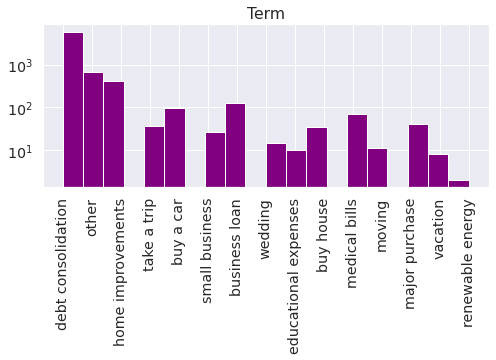

In [30]:
figsize = (8, 3)
plt.figure(figsize=figsize)
sns.set(font_scale=1.3)
plt.hist(df_train['Purpose'], bins=20, color='purple', log=True)
plt.xticks(rotation=90)
plt.title(name)
plt.show()

1. **Annual Income.** 
С увеличением годового дохода количество клиентов снижается, что закономерно. Из графика видно, что в районе 7 млн. есть резкий спад, а также после 9 млн. Предположение о том, что свыше 9 млн. - это выборсы, подтверждается.

2. **Months since last delinquent.** 
Как отмечалось ранее, значения больше 100 можно посчитать как выбросы.

3. **Credit Score.** 
Из графика видно, что данные практически делятся на 2 группы (< 1000 и > 6000). Очень неоднородные данные.

4. **Maximum Open Credit.** 
Сильно выбиваются значения равные нулю, как и отмечалось ранее.

5. **Current Loan Amount.** 
Явный перевес клиентов, у которых текущая сумма криедита менее 20 млн. Как отмечалось ранее, выделяется группа со значениями около 100 млн.

6. **Current Credit Balance.** 
Свыше 3 млн. у значений кредитного баланса наблюдаются резкие скачки. Возможно, стоит отнести остальные случаи к выбросам именно от этого значения.

7. **Home Ownership.** 
Как отмечалось ранее, группа Have Mortgage по отношению к другим категориям очень мала. Вероятно, ее следует исключить.

8. **Term.**
Сильный перевес значений в сторону краткосрочных кредитов, как и отмечалось ранее.

9. **Purpose.**
Наиболее распространенные значения debt consolidation, home improvements, others. Вероятно, можно объединить все остальные категории с категорией other.

#### Матрица корреляций признаков и целевой переменной ####

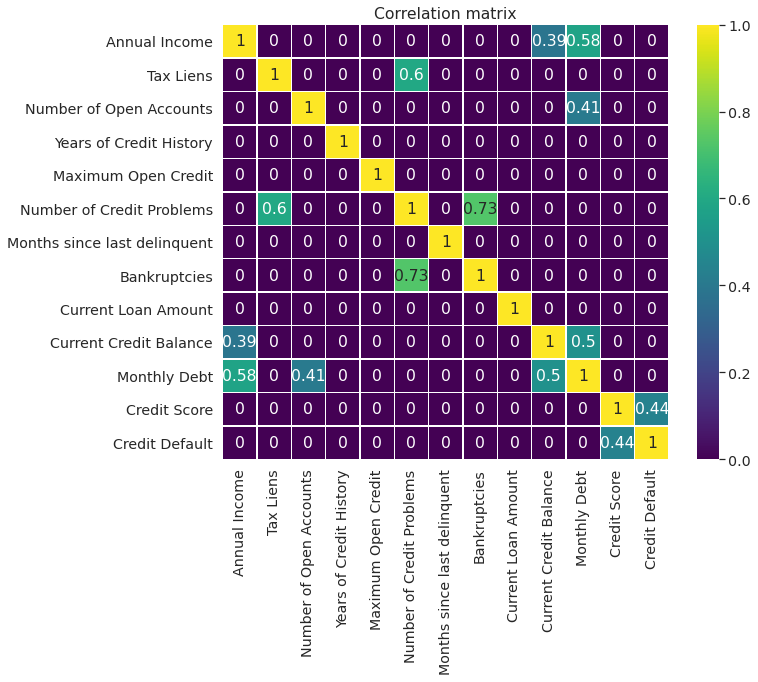

In [31]:
plt.figure(figsize = (10,8))

sns.set(font_scale=1.3)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='viridis')

plt.title('Correlation matrix')
plt.show()

Исходя из матрицы корреляций, наиболее очевидна связь между признаком **Credit Score** и целевой переменной **Credit Default** (0.44). 

Также прослеживается линейная зависимость между **Number of Credit Problems** с признаками **Bankruptcies** и **Tax Liens** (0.73 и 0.6 соответственно).

#### Распределение вещественных признаков на train и test ####

In [32]:
num_features_with_no_target = list(df_train_num_features)[:-1]

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


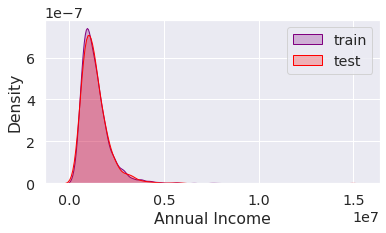

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


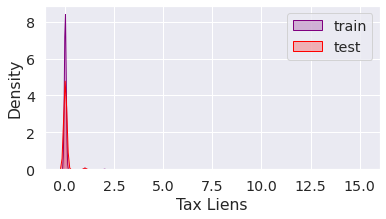

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


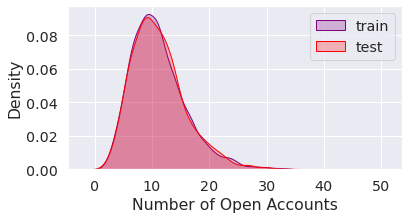

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


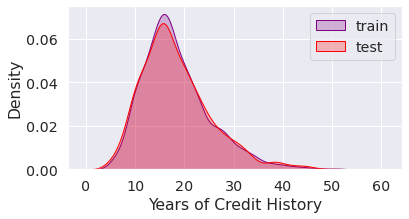

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


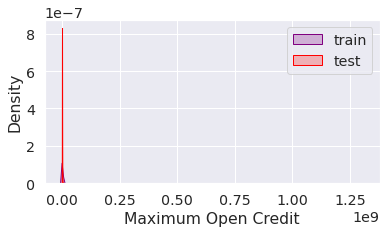

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


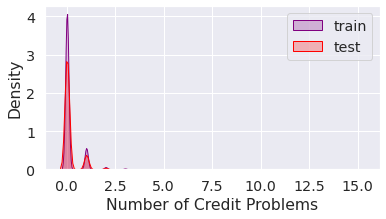

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


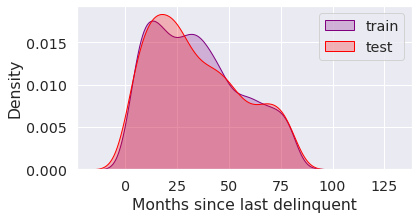

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


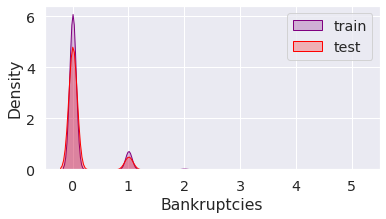

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


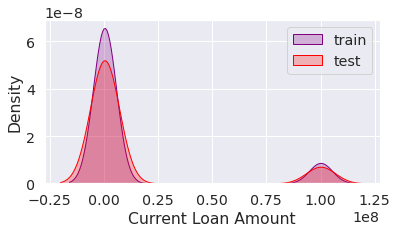

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


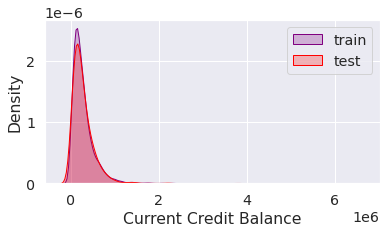

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


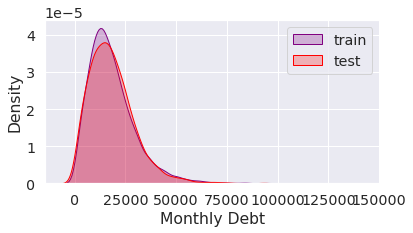

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


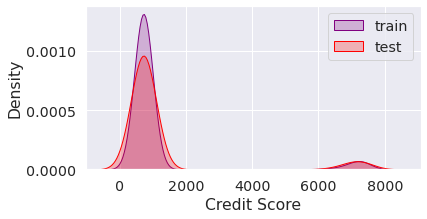

In [33]:
figsize = (6, 3)
for name in num_features_with_no_target:
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.3)
    sns.kdeplot(df_train[name], shade=True, label='train', color='purple')
    sns.kdeplot(df_test[name], shade=True, label='test', color='red')
    print(name)
    print(mannwhitneyu(df_train[name], df_test[name]))
    plt.legend()
    plt.show()

Распределение почти всех вещественных признаков в выборках train и test примерно совпадает, так как pvalue больше 0.05. 

Одинственный признак **Bankruptcies** имеет значение pvalue около 0.036.

#### Распределение категориальных признаков на train и test ####

In [34]:
cat_features = list(df_train.select_dtypes(include=['object']))

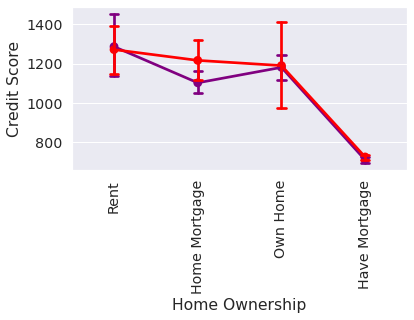

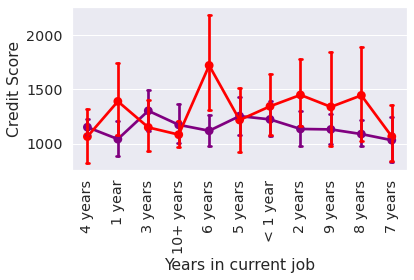

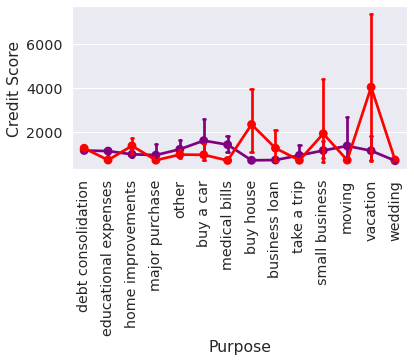

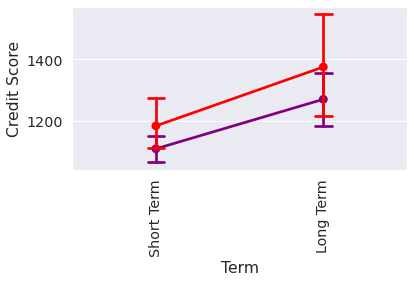

In [35]:
num_feature = 'Credit Score'
for name in cat_features:
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.3)
    sns.pointplot(x=name, y=num_feature, data=df_train, capsize=.1, label='train', color='purple')
    sns.pointplot(x=name, y=num_feature, data=df_test, capsize=.1, label='test', color='red')
    plt.xticks(rotation=90)
    #plt.title(name) 
    plt.show()

Так как целевая переменная имеет зависимость с признаком **Credit Score**, возьмем его для анализа распределение категориальных признаков в выборках train и test.

1. **Home Ownership.** Хорошее совпадение.

2. **Years in current job.** Доверительные интервалы не пересекаются в значении 6 years. Вероятно, его следует исключить.

3. **Purpose.** Доверительные интервалы не пересекаются в значениях educational expenses, buy a car, medical bills и buy house. Если данные признаки объединить с other, возможно ситуация улучшится.

4. **Term.** Неплохое совпадение.

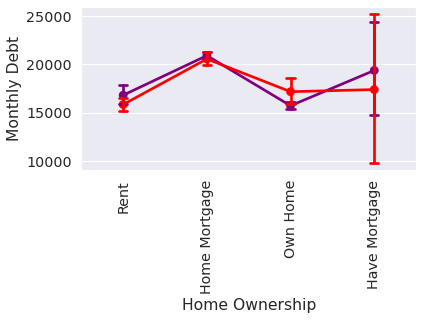

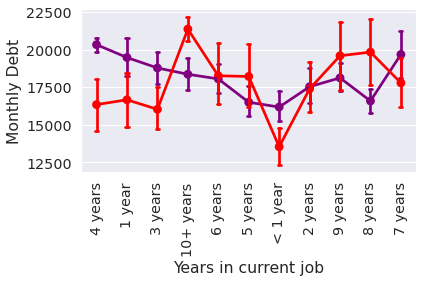

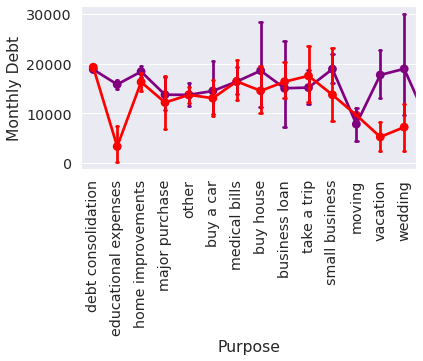

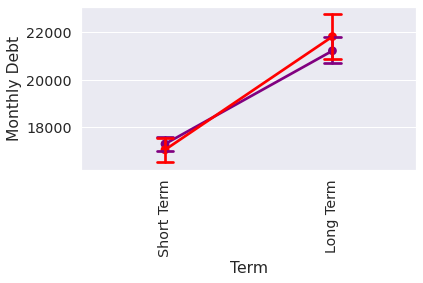

In [36]:
num_feature = 'Monthly Debt'
for name in cat_features:
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.3)
    sns.pointplot(x=name, y=num_feature, data=df_train, capsize=.1, label='train', color='purple')
    sns.pointplot(x=name, y=num_feature, data=df_test, capsize=.1, label='test', color='red')
    plt.xticks(rotation=90)
    #plt.title(name) 
    plt.show()

Посмотрим схожесть категориальных признаков в выборках train и test на основе признака **Monthly Debt**.

1. **Home Ownership.** Хорошее совпадение.

2. **Years in current job.** Доверительные интервалы не пересекаются в значениях 4, 3, 10+, < 1, 8, 7 years. Довольно много несовпадений.

3. **Purpose.** Доверительные интервалы не пересекаются в значениях educational expenses (снова признак выделяется) и vacation.

4. **Term.** Хорошее совпадение.

В целом выборки train и test неплохо совпадают, что дает возможность предполагать хорошую предсказательную способность модели.

### Разбиение выборки на train и test ###

In [37]:
df_train.drop('Credit Default', axis=1, inplace=True)

In [38]:
X_train, X_valid, z_train, z_valid = train_test_split(df_train, y_train, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y_train)

display(z_train.value_counts(normalize=True), z_valid.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

#### Заполнение пропусков и обработка выбросов ####

In [39]:
class FeatureImputer: 
    
    def __init__(self):
        self.medians=None
        self.mean=None
        self.mode=None
        
    def fit(self, X_train):
        self.medians = X_train.median() 
        self.mean = X_train.mean()
        self.mode = X_train.mode()
    
    def transform(self, X_train):        
        
        X_train = X_train.copy()
        
        # Annual Income
        X_train.loc[X_train['Annual Income'] >= 7000000, 'Annual Income'] = 6000000
        
        condition_Annual_Income = (X_train['Annual Income'].isna())
        X_train.loc[condition_Annual_Income, 'Annual Income'] = self.medians['Annual Income']
        
        # Bankruptcies
        X_train.loc[X_train['Bankruptcies'] >= 3.0, 'Annual Income'] = 2.0
        
        condition_Bankruptcies = (X_train['Bankruptcies'].isna())
        X_train.loc[condition_Bankruptcies, 'Bankruptcies'] = self.medians['Bankruptcies']
        
        # Maximum Open Credit
        X_train.loc[X_train['Maximum Open Credit'] >= 10000000, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
        # Current Credit Balance
        X_train.loc[X_train['Current Credit Balance'] >= 3000000, 'Current Credit Balance'] = self.medians['Current Credit Balance']
           
        # Credit Score
        condition_Credit_Score = (X_train['Credit Score'].isna())
        X_train.loc[condition_Credit_Score, 'Credit Score'] = self.medians['Credit Score']
        
        # Months since last delinquent
        if 'Months since last delinquent' in X_train.columns:
            X_train.drop('Months since last delinquent', axis=1, inplace=True)
        
        # Years in current job
        condition_Years_in_current_job = (X_train['Years in current job'].isna())
        X_train.loc[condition_Years_in_current_job, 'Years in current job'] = self.mode['Years in current job'][0]       
        
        # Home Ownership
        X_train.loc[X_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage' 
        
        
        return X_train
        

In [40]:
imputer = FeatureImputer()

imputer.fit(X_train) # расчет медиан и средних значений

X_train = imputer.transform(X_train)
X_valid = imputer.transform(X_valid)
df_test = imputer.transform(df_test)

#### Переведение строковых признаков в числовое представление ####

In [41]:
class BinaryFeatureGenerator():
    
    def __init__(self):
        self.Home_Ownership_dummy = None
        self.Years_in_current_job_dummy = None
        self.Purpose_dummy = None
        self.Term_dummy = None
        
    def fit(self, X_train):    
        
        # Home Ownership
        self.Home_Ownership_dummy = pd.get_dummies(X_train['Home Ownership'])
        
        # Years in current job
        self.Years_in_current_job_dummy = pd.get_dummies(X_train['Years in current job'])
        
        # Purpose
        self.Purpose_dummy = pd.get_dummies(X_train['Purpose'])
        
        # Term
        self.Term_dummy = pd.get_dummies(X_train['Term'])
                
                   
    def transform(self, X_train):
        
        # Home Ownership
        X_train[self.Home_Ownership_dummy.columns] = self.Home_Ownership_dummy
        X_train.drop('Home Ownership', axis=1, inplace=True)
        
        # Years in current job
        X_train[self.Years_in_current_job_dummy.columns] = self.Years_in_current_job_dummy
        X_train.drop('Years in current job', axis=1, inplace=True)
        
        # Purpose
        X_train[self.Purpose_dummy.columns] = self.Purpose_dummy
        X_train.drop('Purpose', axis=1, inplace=True)
        
        # Term
        X_train[self.Term_dummy.columns] = self.Term_dummy
        X_train.drop('Term', axis=1, inplace=True)
        
            
        return X_train
    

In [42]:
binary_features = BinaryFeatureGenerator()

binary_features.fit(X_train)

X_train = binary_features.transform(X_train)
X_valid = binary_features.transform(X_valid)
df_test = binary_features.transform(df_test)

### Построение модели ###

In [43]:
def get_classification_report(z_train_true, z_train_pred, z_valid_true, z_valid_pred):
    print('TRAIN\n\n' + classification_report(z_train_true, z_train_pred))
    print('VALID\n\n' + classification_report(z_valid_true, z_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(z_valid_true, z_valid_pred))

In [44]:
def evaluate_preds(model, X_train, X_valid, z_train, z_valid):
    z_train_pred = model.predict(X_train)
    z_valid_pred = model.predict(X_valid)

    get_classification_report(z_train, z_train_pred, z_valid, z_valid_pred)

In [45]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:3},
                                 n_estimators=20
                                )
model_lgbm.fit(X_train, z_train)

evaluate_preds(model_lgbm, X_train, X_valid, z_train, z_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.72      0.82      3771
           1       0.55      0.87      0.68      1479

    accuracy                           0.76      5250
   macro avg       0.74      0.80      0.75      5250
weighted avg       0.83      0.76      0.78      5250

VALID

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1616
           1       0.44      0.62      0.52       634

    accuracy                           0.67      2250
   macro avg       0.63      0.66      0.64      2250
weighted avg       0.72      0.67      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1122  494
1                240  394
CPU times: user 447 ms, sys: 6.09 ms, total: 454 ms
Wall time: 165 ms


Из отчета видно, что на выборке **train** результат предсказания класса '1' лучше (f1-score: 0.67), чем на выборке **valid** (f1-score: 0.51), следовательно, есть момент переобучения. 

**Что можно сделать:**
1. Еще раз взглянуть на обработку пропусков и выбросов.
2. Отобрать наиболее важные признаки.
3. Почистить значения, которые могут мешать предсказаниям.
4. Поискать наилучшие параметры для модели.
5. Попробовать использовать другую модель.

#### Определение наиболее важных признаков ####

In [46]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

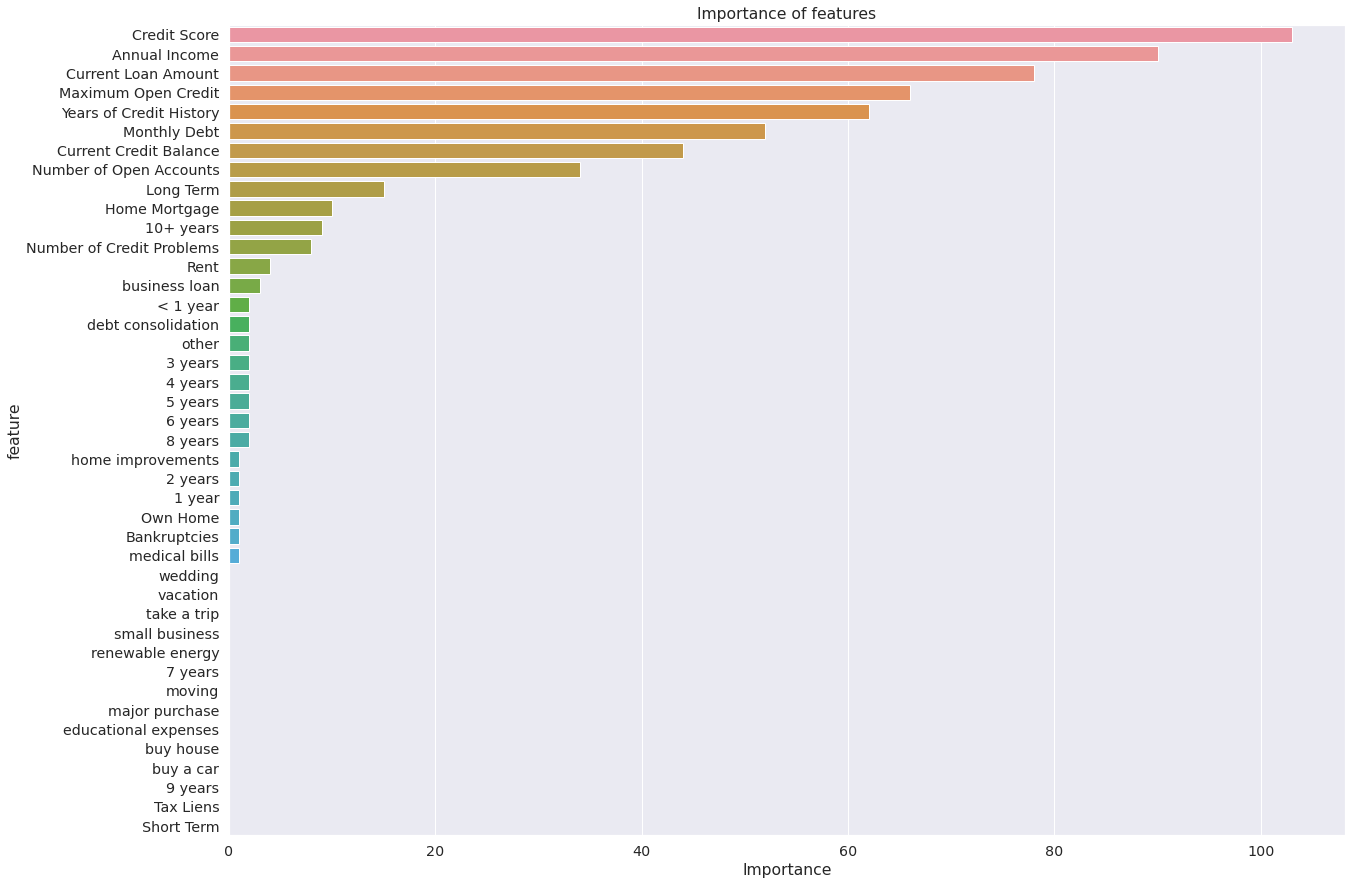

In [47]:
important_features_top = show_feature_importances(X_train.columns,
                                                  model_lgbm.feature_importances_, get_top=28)

In [48]:
important_features_top

['Credit Score',
 'Annual Income',
 'Current Loan Amount',
 'Maximum Open Credit',
 'Years of Credit History',
 'Monthly Debt',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Long Term',
 'Home Mortgage',
 '10+ years',
 'Number of Credit Problems',
 'Rent',
 'business loan',
 '< 1 year',
 'debt consolidation',
 'other',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '8 years',
 'home improvements',
 '2 years',
 '1 year',
 'Own Home',
 'Bankruptcies',
 'medical bills']

#### Поиск по сетке наилучшых параметров для модели ####

In [49]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [50]:
cv = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)

In [51]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_lgbm, cv=cv, verbose=0, scoring='f1')
grid_search.fit(X_train, z_train)
display(grid_search.best_params_, grid_search.best_score_)

{'reg_lambda': 5}

0.5482901428793292

CPU times: user 11.5 s, sys: 198 ms, total: 11.7 s
Wall time: 3.12 s


### Финальная модель ###

In [52]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:3.3},
                                 n_estimators=20,
                                 learning_rate=0.1,
                                 max_depth=5,
                                 reg_lambda=0.5
                                )
model_lgbm.fit(X_train[important_features_top], z_train)

evaluate_preds(model_lgbm, X_train[important_features_top], X_valid[important_features_top], z_train, z_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.48      0.63      3771
           1       0.40      0.88      0.55      1479

    accuracy                           0.59      5250
   macro avg       0.66      0.68      0.59      5250
weighted avg       0.77      0.59      0.61      5250

VALID

              precision    recall  f1-score   support

           0       0.88      0.51      0.65      1616
           1       0.40      0.81      0.53       634

    accuracy                           0.60      2250
   macro avg       0.64      0.66      0.59      2250
weighted avg       0.74      0.60      0.61      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               829  787
1               118  516
CPU times: user 260 ms, sys: 6.12 ms, total: 266 ms
Wall time: 88.8 ms


In [53]:
preds_test = pd.DataFrame({
    'Id': (i for i in range(0, df_test.shape[0]))
})

In [54]:
# делаем предсказание
y_pred_test = model_lgbm.predict(df_test[important_features_top])

preds_test['Credit Default'] = y_pred_test
preds_test.to_csv('./predictions.csv', index=False)

preds_test.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0


In [55]:
preds_test.shape[0]

2500